In [5]:
import os
import numpy as np
import setigen as stg
import blimpy as bl
import astropy.units as u
from blimpy import Waterfall

# === INPUT FILE ===
input_h5 = '/datax/scratch/jaym/data0005-beam0000.h5'
output_h5 = '/datax/scratch/jaym/data0005-beam0000-injected-full.h5'
injection_log = '/datax/scratch/jaym/injection_parameters.npy'
chunk_size = 1024  # Number of frequency channels per chunk

# === Load input HDF5 ===
fb = Waterfall(input_h5, load_data=True)
freqs, _ = fb.grab_data()
full_data = fb.data[0]  # shape: (time, freq)
n_time, n_freq = full_data.shape

print(f"Loaded data shape: {full_data.shape}")
print(f"Freq range: {freqs.min():.6f} – {freqs.max():.6f} MHz")

# === Generate injection parameters aligned with file ===
f_min, f_max = freqs.min(), freqs.max()
center_freqs = np.arange(f_min + 0.008, f_max - 0.008, 0.032)
drift_rates = np.random.uniform(-2, 2, len(center_freqs))  # Hz/s
snrs = np.random.uniform(20, 100, len(center_freqs))
widths = np.ones_like(snrs)

# === Inject in frequency chunks ===
injected_chunks = []
chunk_count = n_freq // chunk_size
header = fb.header
df = abs(freqs[1] - freqs[0]) * u.MHz
dt = header['tsamp'] * u.s
ascending = header['foff'] < 0
fch1 = freqs[0] * u.MHz if ascending else freqs[-1] * u.MHz

for i in range(chunk_count):
    start = i * chunk_size
    end = (i + 1) * chunk_size
    chunk_freq_min = freqs[start]
    chunk_freq_max = freqs[end - 1]

    # Subset data and create Frame
    chunk_data = full_data[:, start:end]
    frame = stg.Frame.from_data(
        df=df,
        dt=dt,
        fch1=chunk_freq_min * u.MHz,
        ascending=True,
        data=chunk_data,
        metadata=header
    )

    # Inject signals that fall in this chunk
    count_injected = 0
    for f, d, s, w in zip(center_freqs, drift_rates, snrs, widths):
        if chunk_freq_min <= f <= chunk_freq_max:
            frame.add_signal(
                path=stg.constant_path(f_start=f * u.MHz, drift_rate=d * u.Hz/u.s),
                t_profile=stg.constant_t_profile(level=frame.get_intensity(snr=s)),
                f_profile=stg.gaussian_f_profile(width=w * df),
                bp_profile=stg.constant_bp_profile(level=1)
            )
            count_injected += 1

    print(f"Chunk {i+1}/{chunk_count}: injected {count_injected} signals")

    # Collect the injected chunk
    injected_chunks.append(frame.data)

# === Combine injected chunks into full array ===
print("Merging chunks...")
injected_data = np.hstack(injected_chunks)  # shape: (time, full_freq)

# === Create a new Frame for the full injected data ===
final_frame = stg.Frame.from_data(
    df=df,
    dt=dt,
    fch1=fch1,
    ascending=True,
    data=injected_data,
    metadata=header
)

# === Save output ===
final_frame.save_h5(output_h5)
np.save(injection_log, np.array([center_freqs, drift_rates, snrs, widths]))

print(f"✅ Injected full file saved to {output_h5}")
print(f"📄 Injection metadata saved to {injection_log}")



Loaded data shape: (1, 16777216)
Freq range: 2851.500001 – 2883.499999 MHz
Chunk 1/16384: injected 0 signals
Chunk 2/16384: injected 0 signals
Chunk 3/16384: injected 0 signals
Chunk 4/16384: injected 0 signals
Chunk 5/16384: injected 0 signals
Chunk 6/16384: injected 0 signals
Chunk 7/16384: injected 0 signals
Chunk 8/16384: injected 0 signals
Chunk 9/16384: injected 0 signals
Chunk 10/16384: injected 0 signals
Chunk 11/16384: injected 0 signals
Chunk 12/16384: injected 0 signals
Chunk 13/16384: injected 0 signals
Chunk 14/16384: injected 0 signals
Chunk 15/16384: injected 0 signals
Chunk 16/16384: injected 0 signals
Chunk 17/16384: injected 0 signals
Chunk 18/16384: injected 0 signals
Chunk 19/16384: injected 0 signals
Chunk 20/16384: injected 0 signals
Chunk 21/16384: injected 0 signals
Chunk 22/16384: injected 0 signals
Chunk 23/16384: injected 0 signals
Chunk 24/16384: injected 0 signals
Chunk 25/16384: injected 0 signals
Chunk 26/16384: injected 0 signals
Chunk 27/16384: injected

In [ ]:
# splits the file in waterfall_fn into files of 1024 frequency channels
split_fil_paths = split_fil(waterfall_fn='/datax/scratch/jaym/data0005-beam0000.fil', output_dir='/datax/scratch/jaym/split_fils', fchans=1024)

blimpy.waterfall INFO     __write_to_fil_light: Writing the spectra matrix for /datax/scratch/jaym/split_fils/1024_0000.fil in one go.
blimpy.waterfall INFO     Conversion time: 0.00sec
Saved /datax/scratch/jaym/split_fils/1024_0000.fil
blimpy.waterfall INFO     __write_to_fil_light: Writing the spectra matrix for /datax/scratch/jaym/split_fils/1024_0001.fil in one go.
blimpy.waterfall INFO     Conversion time: 0.00sec
Saved /datax/scratch/jaym/split_fils/1024_0001.fil
blimpy.waterfall INFO     __write_to_fil_light: Writing the spectra matrix for /datax/scratch/jaym/split_fils/1024_0002.fil in one go.
blimpy.waterfall INFO     Conversion time: 0.00sec
Saved /datax/scratch/jaym/split_fils/1024_0002.fil
blimpy.waterfall INFO     __write_to_fil_light: Writing the spectra matrix for /datax/scratch/jaym/split_fils/1024_0003.fil in one go.
blimpy.waterfall INFO     Conversion time: 0.00sec
Saved /datax/scratch/jaym/split_fils/1024_0003.fil
blimpy.waterfall INFO     __write_to_fil_light: Writ

In [ ]:
# finding out what the original file header looks like
original_fb = Waterfall('/datax/scratch/jaym/data0005-beam0000.fil')
original_fb.header

{'machine_id': 0,
 'telescope_id': -1,
 'src_raj': <Angle 9.02290278 hourangle>,
 'src_dej': <Angle 18.24208333 deg>,
 'az_start': 0.0,
 'za_start': 0.0,
 'data_type': 1,
 'fch1': 2883.4999990463257,
 'foff': -1.9073486328125e-06,
 'nchans': 16777216,
 'nbeams': 1,
 'ibeam': 0,
 'nbits': 32,
 'tstart': 60594.68818123033,
 'tsamp': 0.524288,
 'nifs': 1,
 'barycentric': 1,
 'pulsarcentric': 1,
 'source_name': 'PHASE_CENTER',
 'rawdatafile': '/mnt/cosmic-storage-1/data3/vla_target_keepraw/24A-343.sb46001740.eb46901750.60'}

In [3]:
# Load the filterbank file
fb = Waterfall('/datax/scratch/jaym/data0005-beam0000.fil', load_data=True)

# Force data load to avoid memmap
_ = fb.data

# Now save as HDF5
fb.write_to_hdf5('/datax/scratch/jaym/data0005-beam0000.h5')

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/jaym/data0005-beam0000.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 3.05sec


In [1]:
# imports
import matplotlib.pyplot as plt
from blimpy import Waterfall
from setigen.split_utils import split_fil
import setigen as stg
import astropy.units as u
import numpy as np
import h5py
import os

%matplotlib inline

In [2]:
fb = Waterfall('/datax/scratch/jaym/data0005-beam0000.h5')

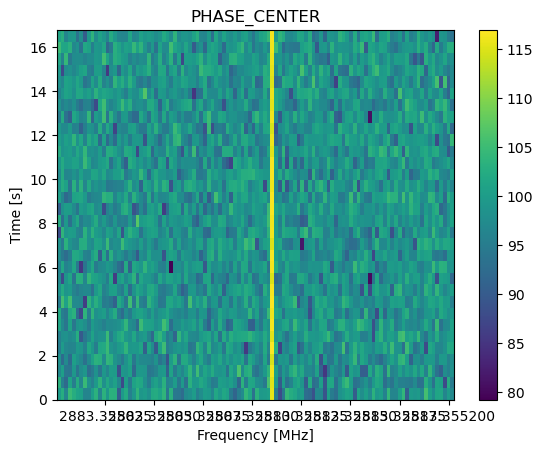

In [3]:
fb.plot_waterfall(2883.3550,2883.3552)

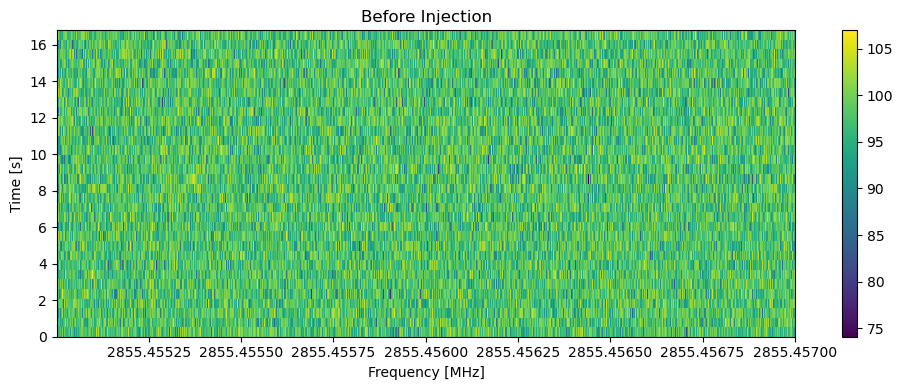

In [4]:
# Plot before injection
plt.figure(figsize=(10, 4))
fb.plot_waterfall(2855.455,2855.457)
plt.title('Before Injection')
plt.tight_layout()

In [10]:
frame = stg.Frame(waterfall="/datax/scratch/jaym/data0005-beam0000.h5")

In [11]:
frame.add_signal(
    stg.constant_path(f_start=2855.456*u.MHz,
    drift_rate=2*u.Hz/u.s),
    stg.constant_t_profile(level=frame.get_intensity(snr=30)),
    stg.gaussian_f_profile(width=2*u.Hz),
    stg.constant_bp_profile(level=1)
)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(32, 16777216))

In [12]:
frame.save_h5('/datax/scratch/jaym/data0005-beam0000-injected.h5')

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/jaym/data0005-beam0000-injected.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 2.92sec


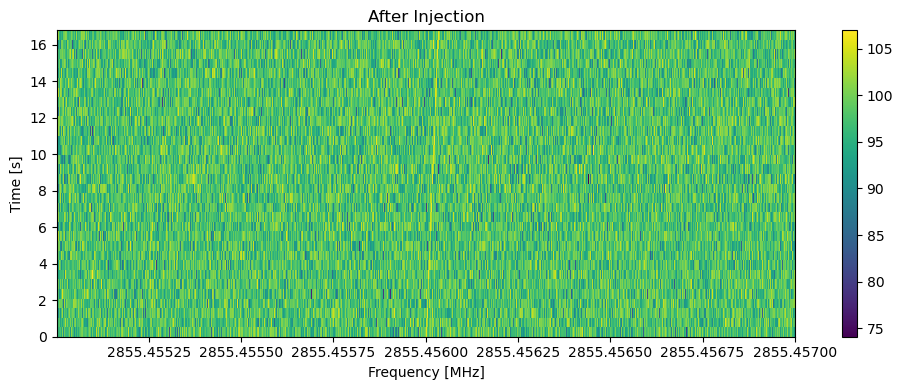

In [13]:
injected_fb = Waterfall('/datax/scratch/jaym/data0005-beam0000-injected.h5')

plt.figure(figsize=(10, 4))
injected_fb.plot_waterfall(2855.455,2855.457)
plt.title('After Injection')
plt.tight_layout()

In [22]:
!seticore

usage: seticore [input]
seticore version: 1.0.6
seticore options:
  -h [ --help ]                produce help message
  --input arg                  alternate way of setting the input file(s) or 
                               directory
  --output arg                 the output as .dat file, .hits file, or 
                               directory. defaults to <input>.dat
  -M [ --max_drift ] arg (=10) maximum absolute value of drift, in Hz/sec
  -m [ --min_drift ] arg       minimum absolute value of drift, in Hz/sec. 
                               Using this is discouraged.
  -s [ --snr ] arg (=25)       minimum SNR to report a hit
  --recipe_dir arg             the directory to find beamforming recipes in. 
                               set this to beamform.
  --recipe arg                 the beamforming recipe file. set this to 
                               beamform.
  --h5_dir arg                 optional directory to save .h5 files containing 
                               po

In [6]:
!seticore --input "/datax/scratch/jaym/data0005-beam0000.h5" --output "seticore_output/cosmic_file.dat"
!seticore --input "/datax/scratch/jaym/data0005-beam0000-injected-full.h5" --output "seticore_output/cosmic_file_injected.dat"

welcome to seticore, version 1.0.6
running in dedoppler mode.
loading input from /datax/scratch/jaym/data0005-beam0000.h5
dedoppler parameters: max_drift=10.00 min_drift=0.0000 snr=25.00
writing output to seticore_output/cosmic_file.dat
hit: coarse channel = 0, index = 33609, snr = 60.03456, drift rate = -0.00000 (0 bins)
hit: coarse channel = 0, index = 45560, snr = 49.98223, drift rate = -0.00000 (0 bins)
hit: coarse channel = 0, index = 63792, snr = 27.26885, drift rate = 0.11735 (-1 bin)
hit: coarse channel = 0, index = 75964, snr = 153.83780, drift rate = -0.00000 (0 bins)
hit: coarse channel = 0, index = 91068, snr = 54.64148, drift rate = -0.00000 (0 bins)
hit: coarse channel = 0, index = 97542, snr = 46.50642, drift rate = -0.23471 (2 bins)
hit: coarse channel = 0, index = 104907, snr = 173.07935, drift rate = -0.00000 (0 bins)
hit: coarse channel = 0, index = 121681, snr = 39.94947, drift rate = -0.00000 (0 bins)
hit: coarse channel = 0, index = 135842, snr = 259.03677, drift 